In [1]:
import os
import copy
import pickle
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import deepdish as dd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable
from matplotlib.ticker import NullLocator

from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 28})

In [2]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"
fname='galaxies_tng300_072_correct.hdf5'

In [3]:
# SHMR relation for TNG300 massive galaxies
slope_aper_tab0=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/slope_aperture')
slope_out_tab0=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/slope_outskirt')
scatter_aper_tab0=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/scatter_aperture')
scatter_out_tab0=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/scatter_outskirt')

In [4]:
slope_aper_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/uncertainty/slope_aperture')
slope_out_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/uncertainty/slope_outskirt')
scatter_aper_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/uncertainty/scatter_aperture')
scatter_out_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/uncertainty/scatter_outskirt')

In [5]:
slope_aper_tab2=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/direct/slope_aperture')
slope_out_tab2=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/direct/slope_outskirt')
scatter_aper_tab2=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/direct/scatter_aperture')
scatter_out_tab2=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/direct/scatter_outskirt')

In [6]:
slope_aper_tab3=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/uncertainty/slope_aperture')
slope_out_tab3=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/uncertainty/slope_outskirt')
scatter_aper_tab3=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/uncertainty/scatter_aperture')
scatter_out_tab3=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/reff_fit/uncertainty/scatter_outskirt')

In [11]:
color_list=['steelblue','orangered','darkgrey']

In [12]:
tab=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_mass')

In [13]:
sma_list=np.asarray([30,50,75,100,150])
mass_bin=np.arange(11.2,12.5,0.1)
apersize=np.asarray([30,50,100,150])
outer=np.asarray([30,50,75])

In [14]:
scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1

In [15]:
def linear1d(x,a,b):
    return a*x+b

In [16]:
def mpeakfind(tab,bin_num=30):
    numb,bins=np.histogram(tab,bins=bin_num)
    max_value=max(numb)
    max_index=list(numb).index(max_value)
    mpeak=bins[max_index]
    return mpeak

In [17]:
slope_exs_tab={}
slope_exs_err={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_exs'][mask]))
    mask0=(tab['mass_stellar_exs']>10**mpeak)
    ydata=np.log10(tab['mass_halo'][mask&mask0])
    xdata=np.log10(tab['mass_stellar_exs'][mask&mask0])
    popt,pcov=curve_fit(linear1d,xdata,ydata)
    slope_exs_tab[proj]=popt[0]
    slope_exs_err[proj]=np.sqrt(pcov[0,0])
scatter_exs_tab={}
scatter_exs_err1={}
scatter_exs_err2={}
for proj in ('xy','yz','xz'):
    mask=(tab['catsh_primary']==True)&(tab['proj']==proj)&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
    mpeak=mpeakfind(np.log10(tab['mass_stellar_exs'][mask]))
    mask0=(tab['mass_stellar_exs']>10**mpeak)
    std=np.std(np.log10(tab['mass_halo'][mask&mask0])-slope_exs_tab[proj]*np.log10(tab['mass_stellar_exs'][mask&mask0]),ddof=1)
    data=np.log10(tab['mass_halo'][mask&mask0])-slope_exs_tab[proj]*np.log10(tab['mass_stellar_exs'][mask&mask0])
    err=bootstrap((data,),np.std,n_resamples=8000,confidence_level=0.7)
    scatter_exs_err1[proj]=err.confidence_interval[0]
    scatter_exs_err2[proj]=err.confidence_interval[1]
    scatter_exs_tab[proj]=std

In [18]:
slope_exs_tab['yz']

1.2875949944715908

In [19]:
(scatter_exs_tab['yz']+scatter_exs_tab['xz']+scatter_exs_tab['xy'])/3

0.19714847031084673

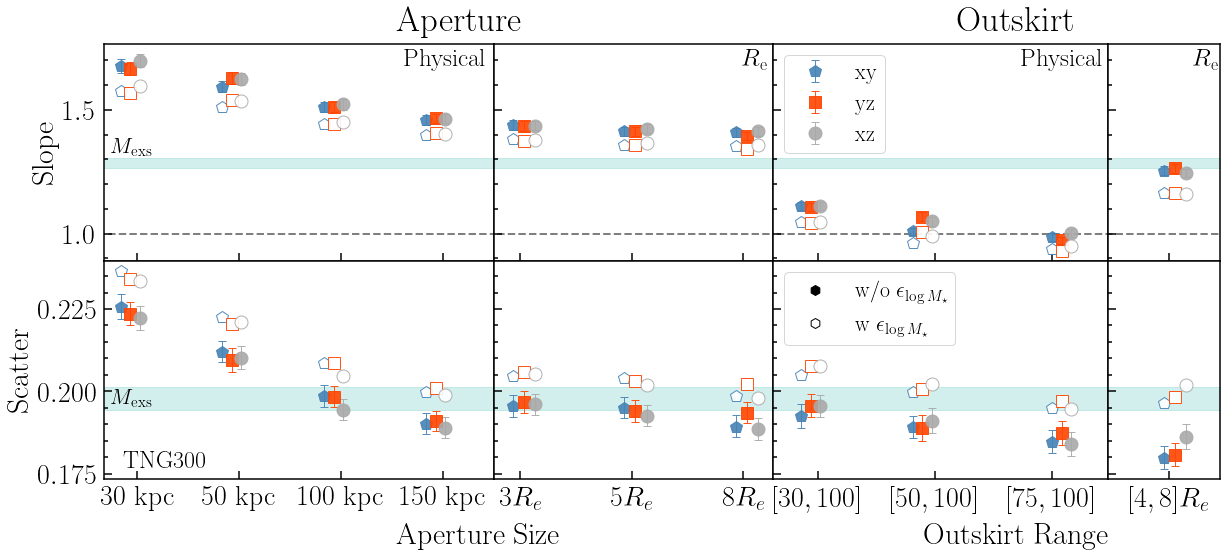

In [20]:
fig=plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2,4, hspace=0, wspace=0,width_ratios=(0.35,0.25,0.3,0.1))
(ax11,ax12,ax21,ax22),(ax31,ax32,ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['xy','yz','xz']
color_list=['steelblue','orangered','darkgrey']
fmtlist=['p','s','o']
mksize_list=[13,12,13]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii,ii])*2.8
    ax11.errorbar(apersize+i0,slope_aper_tab['slope_aper_gal_'+proj],yerr=slope_aper_tab['slope_aper_gal_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_gal_'+proj]-scatter_aper_tab['scatter_aper_gal_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_gal_'+proj+'_err2']-scatter_aper_tab['scatter_aper_gal_'+proj]
    ax31.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_gal_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_gal_'+proj],yerr=slope_out_tab['slope_out_gal_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_gal_'+proj]-scatter_out_tab['scatter_out_gal_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_gal_'+proj+'_err2']-scatter_out_tab['scatter_out_gal_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_gal_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii,ii])*2.8
    ax11.errorbar(apersize+i0,slope_aper_tab_mock['slope_aper_gal_'+proj],mec=col,mfc='White',alpha=0.9, fmt=fmt, 
                 markersize=mksize,label=proj+'_Mock')
    ax31.errorbar(apersize+i0,scatter_aper_tab_mock['scatter_aper_gal_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=mksize)
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab_mock['slope_out_gal_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=mksize)
    ax41.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_gal_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=mksize)


scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*0.3
    ax12.errorbar(apersize+i0,slope_aper_tab['slope_aper_gal_'+proj],yerr=slope_aper_tab['slope_aper_gal_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_gal_'+proj]-scatter_aper_tab['scatter_aper_gal_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_gal_'+proj+'_err2']-scatter_aper_tab['scatter_aper_gal_'+proj]
    ax32.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_gal_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii])*0.2
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_gal_'+proj],yerr=slope_out_tab['slope_out_gal_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_gal_'+proj]-scatter_out_tab['scatter_out_gal_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_gal_'+proj+'_err2']-scatter_out_tab['scatter_out_gal_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_gal_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*0.3
    ax12.errorbar(apersize+i0,slope_aper_tab_mock['slope_aper_gal_'+proj],mec=col,mfc='White',alpha=0.9, fmt=fmt, 
                 markersize=mksize,label=proj+'_Mock')
    ax32.errorbar(apersize+i0,scatter_aper_tab_mock['scatter_aper_gal_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=mksize)
    i0=np.asarray([ii])*0.2
    ax22.errorbar(outer+i0,slope_out_tab_mock['slope_out_gal_'+proj],mec=col,mfc='White', alpha=0.9, fmt=fmt,
             markersize=mksize)
    ax42.errorbar(outer+i0,scatter_out_tab_mock['scatter_out_gal_'+proj],mec=col,mfc='White', alpha=0.9, 
             fmt=fmt,markersize=mksize)


ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm w/o $\epsilon_{\log{M_\star}}$')
ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm w $\epsilon_{\log{M_\star}}$')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax11.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax21.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax31.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax41.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax11.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax12.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax22.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax32.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax42.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax12.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')
    
ax11.set_xlim(25,140)
ax21.set_xlim(25,85)
ax12.set_xlim(2.5,10)
ax22.set_xlim(3,5)
ax11.text(0.75, 1.06, r'\rm Aperture', transform=ax11.transAxes, size=35)
ax31.text(0.05, 0.05, r'\rm TNG300', transform=ax31.transAxes, size=24)
ax21.text(0.55, 1.06, r'\rm Outskirt', transform=ax21.transAxes, size=35)
ax31.text(0.75, -0.3, r'\rm Aperture Size', transform=ax31.transAxes, size=30)
ax41.text(0.45, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax11.text(0.77, 0.9, r'\rm Physical', transform=ax11.transAxes, size=25)
ax12.text(0.89, 0.9, r'$R_{\rm e}$', transform=ax12.transAxes, size=25)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.76, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.1, 0.75, r'\rm Outer size ', transform=ax22.transAxes, size=22)
#ax22.text(0.5, 0.6, r'$=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax11.set_ylabel(r'\rm Slope',fontsize=30)
ax31.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax21.legend(fontsize=22,loc=2)
#ax31.legend(fontsize=25)
ax41.legend(fontsize=22,loc=2)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax31.text(0.02, 0.35, r'$M_{\rm exs}$', transform=ax31.transAxes, size=22)
ax11.text(0.02, 0.5, r'$M_{\rm exs}$', transform=ax11.transAxes, size=22)


ax31.set_xticks([35,65,95,125],[r'$30\ {\rm kpc}$',r'$50\ {\rm kpc}$',r'$100\ {\rm kpc}$',r'$150\ {\rm kpc}$'])
ax32.set_xticks([3.2,6.2,9.2],[r'$3R_e$',r'$5R_e$',r'$8R_e$'])
ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])

for ax in (ax11,ax12,ax21,ax22,ax31,ax32,ax41,ax42):
    ax.xaxis.set_minor_locator(NullLocator())


plt.savefig(fig_dir+"Fig3.png",dpi=200)

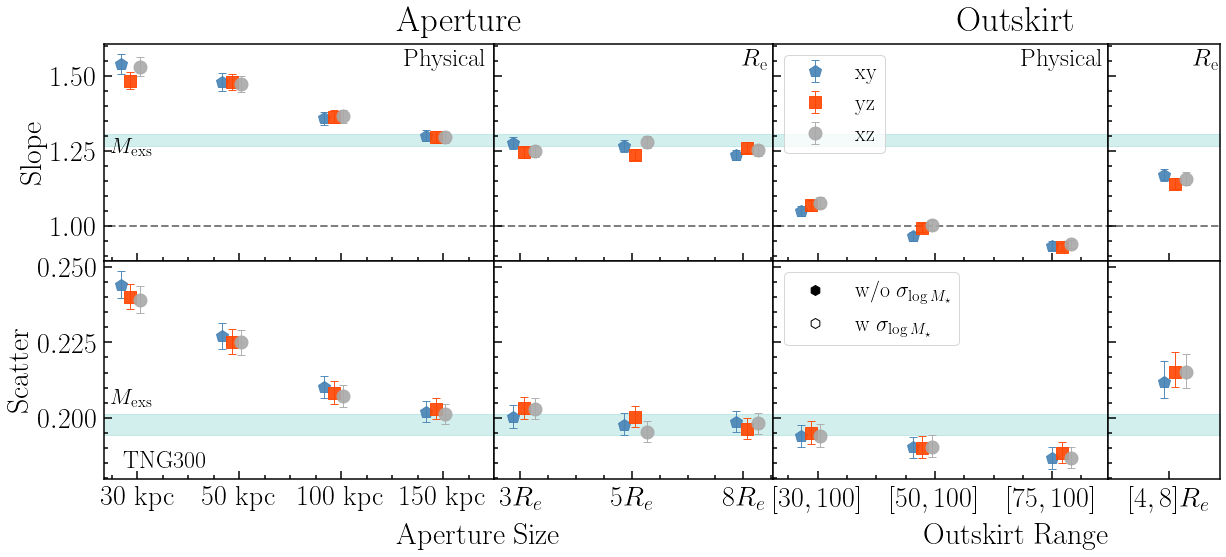

In [19]:
fig=plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2,4, hspace=0, wspace=0,width_ratios=(0.35,0.25,0.3,0.1))
(ax11,ax12,ax21,ax22),(ax31,ax32,ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['xy','yz','xz']
color_list=['steelblue','orangered','darkgrey']
fmtlist=['p','s','o']
mksize_list=[13,12,13]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii,ii])*2.8
    ax11.errorbar(apersize+i0,slope_aper_tab['slope_aper_exs_'+proj],yerr=slope_aper_tab['slope_aper_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_exs_'+proj]-scatter_aper_tab['scatter_aper_exs_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_exs_'+proj+'_err2']-scatter_aper_tab['scatter_aper_exs_'+proj]
    ax31.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_exs_'+proj],yerr=slope_out_tab['slope_out_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_exs_'+proj]-scatter_out_tab['scatter_out_exs_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)



scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*0.3
    ax12.errorbar(apersize+i0,slope_aper_tab['slope_aper_exs_'+proj],yerr=slope_aper_tab['slope_aper_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_exs_'+proj]-scatter_aper_tab['scatter_aper_exs_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_exs_'+proj+'_err2']-scatter_aper_tab['scatter_aper_exs_'+proj]
    ax32.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii])*0.2
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_exs_'+proj],yerr=slope_out_tab['slope_out_exs_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_exs_'+proj]-scatter_out_tab['scatter_out_exs_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_exs_'+proj+'_err2']-scatter_out_tab['scatter_out_exs_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_exs_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)




ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm w/o $\sigma_{\log{M_\star}}$')
ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm w $\sigma_{\log{M_\star}}$')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax11.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax21.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax31.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax41.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax11.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax12.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax22.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax32.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax42.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax12.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')
    
ax11.set_xlim(25,140)
ax21.set_xlim(25,85)
ax12.set_xlim(2.5,10)
ax22.set_xlim(3,5)
ax11.text(0.75, 1.06, r'\rm Aperture', transform=ax11.transAxes, size=35)
ax31.text(0.05, 0.05, r'\rm TNG300', transform=ax31.transAxes, size=24)
ax21.text(0.55, 1.06, r'\rm Outskirt', transform=ax21.transAxes, size=35)
ax31.text(0.75, -0.3, r'\rm Aperture Size', transform=ax31.transAxes, size=30)
ax41.text(0.45, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax11.text(0.77, 0.9, r'\rm Physical', transform=ax11.transAxes, size=25)
ax12.text(0.89, 0.9, r'$R_{\rm e}$', transform=ax12.transAxes, size=25)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.76, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.1, 0.75, r'\rm Outer size ', transform=ax22.transAxes, size=22)
#ax22.text(0.5, 0.6, r'$=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax11.set_ylabel(r'\rm Slope',fontsize=30)
ax31.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax21.legend(fontsize=22,loc=2)
#ax31.legend(fontsize=25)
ax41.legend(fontsize=22,loc=2)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax31.text(0.02, 0.35, r'$M_{\rm exs}$', transform=ax31.transAxes, size=22)
ax11.text(0.02, 0.5, r'$M_{\rm exs}$', transform=ax11.transAxes, size=22)


ax31.set_xticks([35,65,95,125],[r'$30\ {\rm kpc}$',r'$50\ {\rm kpc}$',r'$100\ {\rm kpc}$',r'$150\ {\rm kpc}$'])
ax32.set_xticks([3.2,6.2,9.2],[r'$3R_e$',r'$5R_e$',r'$8R_e$'])
ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])




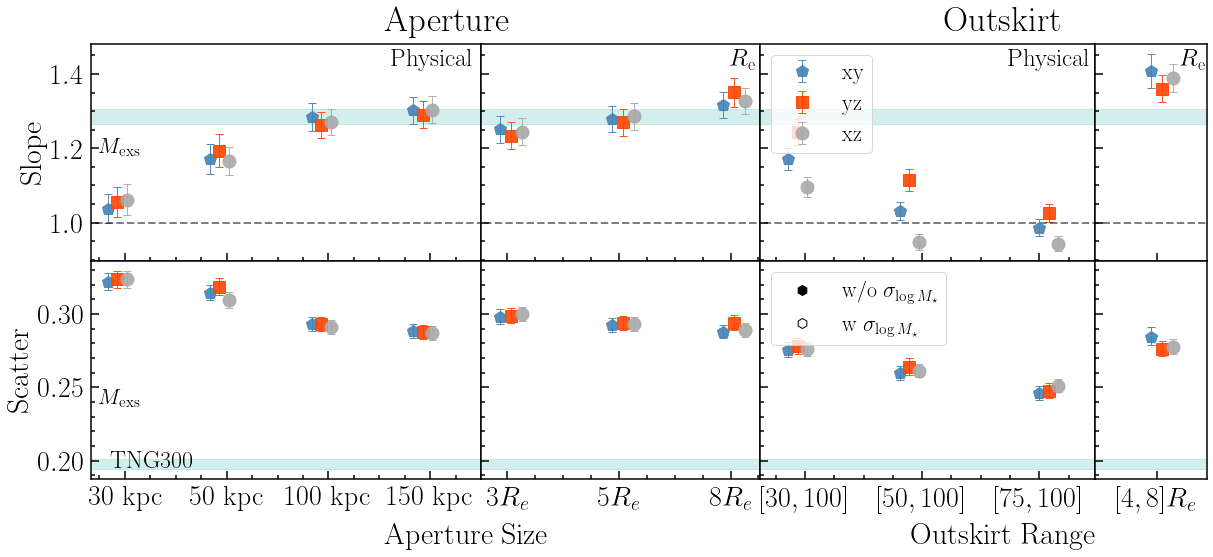

In [20]:
fig=plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2,4, hspace=0, wspace=0,width_ratios=(0.35,0.25,0.3,0.1))
(ax11,ax12,ax21,ax22),(ax31,ax32,ax41,ax42) = gs.subplots(sharex='col', sharey='row')
projlist=['xy','yz','xz']
color_list=['steelblue','orangered','darkgrey']
fmtlist=['p','s','o']
mksize_list=[13,12,13]

scatter_aper_tab=scatter_aper_tab0[scatter_aper_tab0['aperture_size']!=75]
slope_aper_tab=slope_aper_tab0[slope_aper_tab0['aperture_size']!=75]
slope_out_tab=slope_out_tab0
scatter_out_tab=scatter_out_tab0
scatter_aper_tab_mock=scatter_aper_tab1[scatter_aper_tab1['aperture_size']!=75]
slope_aper_tab_mock=slope_aper_tab1[slope_aper_tab1['aperture_size']!=75]
slope_out_tab_mock=slope_out_tab1
scatter_out_tab_mock=scatter_out_tab1
apersize=np.asarray([30,60,90,120])
outer=np.asarray([30,50,75])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii,ii])*2.8
    ax11.errorbar(apersize+i0,slope_aper_tab['slope_aper_ins_'+proj],yerr=slope_aper_tab['slope_aper_ins_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_ins_'+proj]-scatter_aper_tab['scatter_aper_ins_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_ins_'+proj+'_err2']-scatter_aper_tab['scatter_aper_ins_'+proj]
    ax31.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_ins_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii,ii,ii])*1.7
    ax21.errorbar(outer+i0,slope_out_tab['slope_out_ins_'+proj],yerr=slope_out_tab['slope_out_ins_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_ins_'+proj]-scatter_out_tab['scatter_out_ins_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_ins_'+proj+'_err2']-scatter_out_tab['scatter_out_ins_'+proj]
    ax41.errorbar(outer+i0,scatter_out_tab['scatter_out_ins_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)



scatter_aper_tab=scatter_aper_tab2[(scatter_aper_tab2['aperture_size']>2)&(scatter_aper_tab2['aperture_size']<9)&(scatter_aper_tab2['aperture_size']!=4)]
slope_aper_tab=slope_aper_tab2[(slope_aper_tab2['aperture_size']>2)&(slope_aper_tab2['aperture_size']<9)&(slope_aper_tab2['aperture_size']!=4)]
slope_out_tab=slope_out_tab2[slope_out_tab2['outskirt_inner_size']==4]
scatter_out_tab=scatter_out_tab2[scatter_out_tab2['outskirt_inner_size']==4]
scatter_aper_tab_mock=scatter_aper_tab3[(scatter_aper_tab3['aperture_size']>2)&(scatter_aper_tab3['aperture_size']<9)&(scatter_aper_tab3['aperture_size']!=4)]
slope_aper_tab_mock=slope_aper_tab3[(slope_aper_tab3['aperture_size']>2)&(slope_aper_tab3['aperture_size']<9)&(slope_aper_tab3['aperture_size']!=4)]
slope_out_tab_mock=slope_out_tab3[slope_out_tab3['outskirt_inner_size']==4]
scatter_out_tab_mock=scatter_out_tab3[scatter_out_tab3['outskirt_inner_size']==4]
apersize=np.asarray([3,6,9])
outer=np.asarray([4])

for ii in range(3):
    mksize=mksize_list[ii]
    proj=projlist[ii]
    col=color_list[ii]
    fmt=fmtlist[ii]
    i0=np.asarray([ii,ii,ii])*0.3
    ax12.errorbar(apersize+i0,slope_aper_tab['slope_aper_ins_'+proj],yerr=slope_aper_tab['slope_aper_ins_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=proj+'_Origin')
    err1=scatter_aper_tab['scatter_aper_ins_'+proj]-scatter_aper_tab['scatter_aper_ins_'+proj+'_err1']
    err2=scatter_aper_tab['scatter_aper_ins_'+proj+'_err2']-scatter_aper_tab['scatter_aper_ins_'+proj]
    ax32.errorbar(apersize+i0,scatter_aper_tab['scatter_aper_ins_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)
    i0=np.asarray([ii])*0.2
    ax22.errorbar(outer+i0,slope_out_tab['slope_out_ins_'+proj],yerr=slope_out_tab['slope_out_ins_'+proj+'_err'],color=col, alpha=0.9, fmt=fmt,
            capsize=4, capthick=1, elinewidth=1, markersize=mksize,label=r'\rm '+proj)
    err1=scatter_out_tab['scatter_out_ins_'+proj]-scatter_out_tab['scatter_out_ins_'+proj+'_err1']
    err2=scatter_out_tab['scatter_out_ins_'+proj+'_err2']-scatter_out_tab['scatter_out_ins_'+proj]
    ax42.errorbar(outer+i0,scatter_out_tab['scatter_out_ins_'+proj],yerr=(err1,err2),color=col, alpha=0.9, 
             capsize=4, capthick=1, elinewidth=1,fmt=fmt,markersize=mksize)




ax41.errorbar((10,20),(0.2,0.2),color='black',fmt='h',markersize=10,label=r'\rm w/o $\sigma_{\log{M_\star}}$')
ax41.errorbar((10,20),(0.2,0.2),mec='black',mfc='White',fmt='h',markersize=10,label=r'\rm w $\sigma_{\log{M_\star}}$')

x1=np.arange(20,180,20)
x2=np.arange(20,100,10)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax11.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax21.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax31.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax41.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax11.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax21.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')

x1=np.arange(2,12,1)
x2=np.arange(2,7,0.5)
y1=slope_exs_tab['xy']+slope_exs_err['xy']+0*x1
y2=slope_exs_tab['xy']-slope_exs_err['xy']+0*x1
y3=scatter_exs_err1['xy']+0*x1
y4=scatter_exs_err2['xy']+0*x1
c0='lightseagreen'
ax12.fill_between(x1,y1,y2,alpha=0.2,color=c0)   
ax22.fill_between(x2,y1,y2,alpha=0.2,color=c0)
ax32.fill_between(x1,y3,y4,alpha=0.2,color=c0,label=r'$M_{\rm exs}$')   
ax42.fill_between(x2,y3,y4,alpha=0.2,color=c0)
ax12.plot(x1,1+0*x1,alpha=0.5,color='black',lw=2,ls='--')   
ax22.plot(x2,1+0*x2,alpha=0.5,color='black',lw=2,ls='--')
    
ax11.set_xlim(25,140)
ax21.set_xlim(25,85)
ax12.set_xlim(2.5,10)
ax22.set_xlim(3,5)
ax11.text(0.75, 1.06, r'\rm Aperture', transform=ax11.transAxes, size=35)
ax31.text(0.05, 0.05, r'\rm TNG300', transform=ax31.transAxes, size=24)
ax21.text(0.55, 1.06, r'\rm Outskirt', transform=ax21.transAxes, size=35)
ax31.text(0.75, -0.3, r'\rm Aperture Size', transform=ax31.transAxes, size=30)
ax41.text(0.45, -0.3, r'\rm Outskirt Range', transform=ax41.transAxes, size=30)
ax11.text(0.77, 0.9, r'\rm Physical', transform=ax11.transAxes, size=25)
ax12.text(0.89, 0.9, r'$R_{\rm e}$', transform=ax12.transAxes, size=25)
ax21.text(0.74, 0.9, r'\rm Physical', transform=ax21.transAxes, size=25)
ax22.text(0.76, 0.9, r'$R_{\rm e}$', transform=ax22.transAxes, size=25)
#ax21.text(0.45, 0.75, r'\rm Outer size $=100{\rm kpc}$', transform=ax21.transAxes, size=22)
#ax22.text(0.1, 0.75, r'\rm Outer size ', transform=ax22.transAxes, size=22)
#ax22.text(0.5, 0.6, r'$=8R_{\rm e}$', transform=ax22.transAxes, size=22)
#ax11.set_title(r'\rm Aperture',fontsize=30)
#ax31.set_xlabel(r'\rm Aperture Size/kpc',fontsize=25)
#ax32.set_xlabel(r'\rm Aperture Size/$R_{\rm e}$',fontsize=25)
ax11.set_ylabel(r'\rm Slope',fontsize=30)
ax31.set_ylabel(r'\rm Scatter',fontsize=30)
#ax21.set_title(r'\rm Outskirt [$\#$,100]kpc',fontsize=30)
ax21.legend(fontsize=22,loc=2)
#ax31.legend(fontsize=25)
ax41.legend(fontsize=22,loc=2)
#_= ax41.set_xlabel(r'\rm Outskirt Inner Size/kpc',fontsize=25)
#_= ax42.set_xlabel(r'\rm Outskirt Inner Size/$R_{\rm e}$',fontsize=25)
ax31.text(0.02, 0.35, r'$M_{\rm exs}$', transform=ax31.transAxes, size=22)
ax11.text(0.02, 0.5, r'$M_{\rm exs}$', transform=ax11.transAxes, size=22)


ax31.set_xticks([35,65,95,125],[r'$30\ {\rm kpc}$',r'$50\ {\rm kpc}$',r'$100\ {\rm kpc}$',r'$150\ {\rm kpc}$'])
ax32.set_xticks([3.2,6.2,9.2],[r'$3R_e$',r'$5R_e$',r'$8R_e$'])
ax41.set_xticks([33,54,75],[r'$[30,100]$',r'$[50,100]$',r'$[75,100]$'])
ax42.set_xticks([4.1],[r'$[4,8]R_e$'])




1.0375100946713927

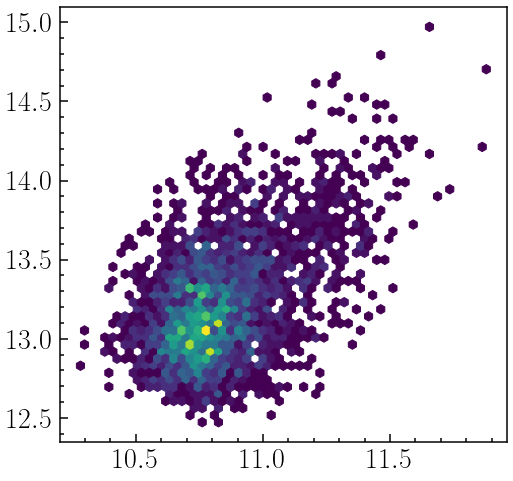

In [40]:
fig=plt.figure(figsize=(8, 8))
mask=(tab['catsh_primary']==True)&(tab['proj']=='xy')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
plt.hexbin(np.log10(tab[mask]['aper_30_ins']),np.log10(tab[mask]['mass_halo']),mincnt=1,gridsize=50)
mpeak=mpeakfind(np.log10(tab['aper_30_ins'][mask]))
mask0=(tab['aper_30_ins']>10**mpeak)
ydata=np.log10(tab['mass_halo'][mask&mask0])
xdata=np.log10(tab['aper_30_ins'][mask&mask0])
popt,pcov=curve_fit(linear1d,xdata,ydata)
popt[0]

1.2836189059079046

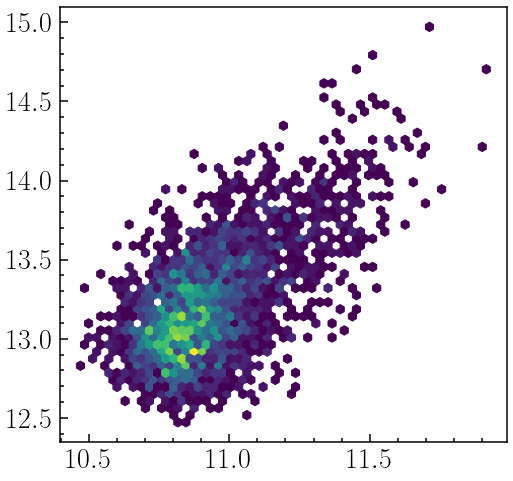

In [41]:
fig=plt.figure(figsize=(8, 8))
mask=(tab['catsh_primary']==True)&(tab['proj']=='xy')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
plt.hexbin(np.log10(tab[mask]['aper_100_ins']),np.log10(tab[mask]['mass_halo']),mincnt=1,gridsize=50)
mpeak=mpeakfind(np.log10(tab['aper_100_ins'][mask]))
mask0=(tab['aper_100_ins']>10**mpeak)
ydata=np.log10(tab['mass_halo'][mask&mask0])
xdata=np.log10(tab['aper_100_ins'][mask&mask0])
popt,pcov=curve_fit(linear1d,xdata,ydata)
popt[0]

In [28]:
slope_aper_tab0['slope_aper_ins_xy']

1.0375100946713927
1.1706457840882705
1.2365642178403875
1.2836189059079046
1.302583405130598


In [42]:
slope_aper_tab

aperture_size,slope_aper_ins_xy,slope_aper_ins_xy_err,slope_aper_ins_yz,slope_aper_ins_yz_err,slope_aper_ins_xz,slope_aper_ins_xz_err,slope_aper_exs_xy,slope_aper_exs_xy_err,slope_aper_exs_yz,slope_aper_exs_yz_err,slope_aper_exs_xz,slope_aper_exs_xz_err,slope_aper_gal_xy,slope_aper_gal_xy_err,slope_aper_gal_yz,slope_aper_gal_yz_err,slope_aper_gal_xz,slope_aper_gal_xz_err,slope_aper_ins_force_xy,slope_aper_ins_force_xy_err,slope_aper_ins_force_yz,slope_aper_ins_force_yz_err,slope_aper_ins_force_xz,slope_aper_ins_force_xz_err,slope_aper_exs_force_xy,slope_aper_exs_force_xy_err,slope_aper_exs_force_yz,slope_aper_exs_force_yz_err,slope_aper_exs_force_xz,slope_aper_exs_force_xz_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3,1.2509990367185129,0.03652797356113445,1.2342700276756282,0.036464481421654156,1.2447154099927524,0.037276039046572944,1.2760599852472059,0.019891962948058523,1.2460866479487887,0.01893015771276237,1.2497608467714156,0.01883083841375483,1.4391744458057134,0.019616542327196163,1.433383952917916,0.019637581972669287,1.4364435966949434,0.019040715931896466,1.1958260106227383,0.031514041457439294,1.224053097239807,0.035178723020789275,1.209011862921524,0.03258149101072057,1.2150788432601072,0.02062403306184161,1.2714090370550735,0.023629942941367547,1.2415266080582597,0.0214089488722462
5,1.2790100936196078,0.0351806254693395,1.2694133923607263,0.035320428036207344,1.2855554718423203,0.035833233822539,1.2675410023576048,0.019905241730444806,1.2382769936338738,0.018523533133824516,1.2808051090527384,0.02018388300373897,1.4131821543414735,0.018214160277381042,1.4123761004397088,0.019103533388297896,1.4234180329561001,0.018802875573059208,1.2742374777837635,0.03367513763666522,1.2703389863164516,0.03299711788155167,1.2834112331936365,0.03434028681225517,1.2617701006549744,0.021440915803761625,1.2243599820942896,0.020024051126648026,1.2670735797625223,0.021553889233027326
8,1.3156820506849933,0.03475933316629168,1.350331669127739,0.0395301459594717,1.3275491789756786,0.03595107916002107,1.2373824942831348,0.017888869090457213,1.2609663472746897,0.018877784696592743,1.2526686252594958,0.01871690830149947,1.4098901241095154,0.018381686159801982,1.393934814448166,0.017434317423195782,1.413471639146125,0.018420546281113035,1.3194428201084338,0.03546108182857853,1.3139334739881505,0.03501669941820047,1.3239276081119518,0.03603570078342799,1.2117061039240933,0.018609791509189254,1.247224789429591,0.01964524833195019,1.2481045195976717,0.019888437439647008
